In [6]:
# data_preprocessing_toolkit.py
import os
from typing import List, Dict, Tuple, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [10]:
# --- Utility: find likely customer id column names in a df ---
def find_customer_id_col(df: pd.DataFrame) -> Optional[str]:
    """
    Attempts to find a likely customer ID column name in the given DataFrame.
    Looks for common variations like 'CustomerID', 'customer_id', 'ID', etc.
    """
    candidates = [c for c in df.columns if c.lower() in (
        'customerid', 'customer_id', 'customer', 'id', 'customer id'
    )]
    return candidates[0] if candidates else None


# --- 1) Merge multiple CSVs into single DataFrame on customer_id-like column ---
def load_and_merge_csvs(csv_paths: List[str], merge_on: Optional[str] = None, how: str = 'outer') -> pd.DataFrame:
    dfs = []

    # Load all CSVs as strings to prevent datatype mismatches
    for p in csv_paths:
        df = pd.read_csv(p, dtype=str)
        df.columns = [c.strip() for c in df.columns]  # clean up column names
        dfs.append(df)

    # Detect merge column if not given
    if merge_on is None:
        candidates = []
        for df in dfs:
            col = find_customer_id_col(df)
            if col:
                candidates.append(col)
        merge_on = candidates[0] if candidates else None

    if merge_on is None:
        raise ValueError("Couldn't detect a customer id column automatically. Pass merge_on explicitly.")

    # Standardize the merge column name across all DataFrames
    for i, df in enumerate(dfs):
        found = None
        for col in df.columns:
            if col.lower() == merge_on.lower():
                found = col
                break
        if found and found != merge_on:
            dfs[i] = df.rename(columns={found: merge_on})

    # Sequentially merge all DataFrames
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on=merge_on, how=how)

    # Convert numeric-looking columns to numeric dtype
    for col in merged.columns:
        if col == merge_on:
            continue
        coerced = pd.to_numeric(merged[col], errors='coerce')
        if coerced.notnull().sum() >= merged.shape[0] * 0.5:
            merged[col] = coerced

    return merged


# --- 2) Use the function to merge your cleaned CSVs ---
csv_files = [
    'customer_demographics_clean.csv',
    'customer_transactions_clean.csv',
    'social_media_interactions_clean.csv'
]

merged_df = load_and_merge_csvs(csv_files)

# --- 3) Save the final merged dataset ---
merged_df.to_csv('merged_customer_data.csv', index=False)

# --- 4) Quick summary after merging ---
print("✅ Merge complete!")
print(f"Rows: {merged_df.shape[0]}, Columns: {merged_df.shape[1]}")
print("\nFirst few columns:\n", merged_df.columns.tolist()[:10])
print("\nSample preview:\n", merged_df.head())


✅ Merge complete!
Rows: 5729, Columns: 16

First few columns:
 ['CustomerID', 'Age', 'Gender', 'Location', 'IncomeLevel', 'SignupDate', 'TransactionID', 'TransactionDate', 'Amount', 'ProductCategory']

Sample preview:
                              CustomerID   Age  Gender         Location  \
0  0009fdd2-ae63-45ca-8d5b-d0ea98381f7b  21.0  Female      Lake George   
1  0009fdd2-ae63-45ca-8d5b-d0ea98381f7b  21.0  Female      Lake George   
2  000c6bbd-533a-432d-922c-ab64197e71c5  25.0    Male  North Oliviaton   
3  000c6bbd-533a-432d-922c-ab64197e71c5  25.0    Male  North Oliviaton   
4  000c6bbd-533a-432d-922c-ab64197e71c5  25.0    Male  North Oliviaton   

  IncomeLevel  SignupDate                         TransactionID  \
0         Low  2020-11-09  86cd577d-4ffd-498d-94ce-e68e6cca8865   
1         Low  2020-11-09  86cd577d-4ffd-498d-94ce-e68e6cca8865   
2        High  2019-11-06                                   NaN   
3        High  2019-11-06                                   NaN   
4

In [13]:
# --- 2) Missing datapoints detection via heatmap ---
def plot_missing_heatmap(df: pd.DataFrame, figsize=(12, 6), cmap="viridis"):
    """Plot missing values heatmap."""
    plt.figure(figsize=figsize)
    sns.heatmap(df.isnull(), cbar=False, cmap=cmap)
    plt.title("Missing values heatmap (True = missing)")
    plt.show()


In [14]:
# --- 3) Imputation helpers ---
def impute_categorical_mode(df: pd.DataFrame, categorical_cols: Optional[List[str]]=None) -> Tuple[pd.DataFrame, Dict[str, object]]:
    """Mode imputation for categorical/object columns. Returns df and dict of used modes."""
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    modes = {}
    for c in categorical_cols:
        mode_val = df[c].mode(dropna=True)
        if len(mode_val) > 0:
            fill = mode_val.iloc[0]
        else:
            fill = "UNKNOWN"
        df[c] = df[c].fillna(fill)
        modes[c] = fill
    return df, modes


def impute_numeric(df: pd.DataFrame, numeric_cols: Optional[List[str]]=None, method: str='mean') -> Tuple[pd.DataFrame, Dict[str, float]]:
    """Impute numeric columns with mean or median."""
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    imputed = {}
    for c in numeric_cols:
        if method == 'mean':
            val = df[c].mean(skipna=True)
        elif method == 'median':
            val = df[c].median(skipna=True)
        else:
            raise ValueError("method must be 'mean' or 'median'")
        df[c] = df[c].fillna(val)
        imputed[c] = val
    return df, imputed


def convert_to_datetime(df: pd.DataFrame, date_cols: Optional[List[str]] = None, infer: bool = True) -> pd.DataFrame:
    """Convert likely date/time columns to datetime."""
    if date_cols is None:
        date_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
    for c in date_cols:
        df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=infer)
    return df


def cap_outliers_iqr_series(s: pd.Series, k: float = 1.5) -> Tuple[pd.Series, float, float]:
    """Cap outliers in a numeric series using IQR."""
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    s_capped = s.clip(lower=lower, upper=upper)
    return s_capped, lower, upper


def winsorize_series_pct(s: pd.Series, lower_pct: float=0.01, upper_pct: float=0.01) -> pd.Series:
    """Winsorize a numeric series (trim extreme values)."""
    arr = s.to_numpy(dtype=float)
    arr_w = winsorize(arr, limits=(lower_pct, upper_pct))
    return pd.Series(arr_w, index=s.index)

In [15]:
# --- 4) Remove duplicates ---
def remove_duplicates(df: pd.DataFrame, subset: Optional[List[str]] = None, keep: str = "first") -> Tuple[pd.DataFrame, int]:
    before = df.shape[0]
    df2 = df.drop_duplicates(subset=subset, keep=keep)
    removed = before - df2.shape[0]
    return df2, removed

In [16]:
# --- 5) Transform numeric features ---
def normalize_columns(df: pd.DataFrame, cols: List[str]) -> Tuple[pd.DataFrame, MinMaxScaler]:
    scaler = MinMaxScaler()
    df_copy = df.copy()
    df_copy[cols] = scaler.fit_transform(df_copy[cols])
    return df_copy, scaler


def standardize_columns(df: pd.DataFrame, cols: List[str]) -> Tuple[pd.DataFrame, StandardScaler]:
    scaler = StandardScaler()
    df_copy = df.copy()
    df_copy[cols] = scaler.fit_transform(df_copy[cols])
    return df_copy, scaler



In [26]:
# --- 6) Example full pipeline ---
def example_pipeline(csv_paths: List[str], merge_on: Optional[str] = None):
    df = load_and_merge_csvs(csv_paths, merge_on=merge_on, how='outer')
    print(f"Loaded merged dataframe shape: {df.shape}")

    # Convert date columns
    df = convert_to_datetime(df)

    # Show missingness
    plot_missing_heatmap(df)

    # Impute missing values
    df, cat_modes = impute_categorical_mode(df)
    df, num_imputes = impute_numeric(df, method='median')
    print("Imputed missing values (categorical and numeric).")

    # Remove duplicates
    df, removed = remove_duplicates(df)
    print(f"Removed {removed} duplicate rows.")

    # Cap numeric outliers
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for c in numeric_cols:
        df[c], _, _ = cap_outliers_iqr_series(df[c])

    # Normalize + Standardize numeric data
    df_norm, norm_scaler = normalize_columns(df, numeric_cols)
    df_std, std_scaler = standardize_columns(df, numeric_cols)

    print("Finished preprocessing pipeline.")
    return {
        "cleaned": df,
        "normalized": df_norm,
        "standardized": df_std,
        "cat_modes": cat_modes,
        "num_imputes": num_imputes
    }

Loaded merged dataframe shape: (5729, 16)


C:\Users\GOD IS GOOD\AppData\Local\Temp\ipykernel_4588\2970454406.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=infer)
C:\Users\GOD IS GOOD\AppData\Local\Temp\ipykernel_4588\2970454406.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=infer)
C:\Users\GOD IS GOOD\AppData\Local\Temp\ipykernel_4588\2970454406.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future ver

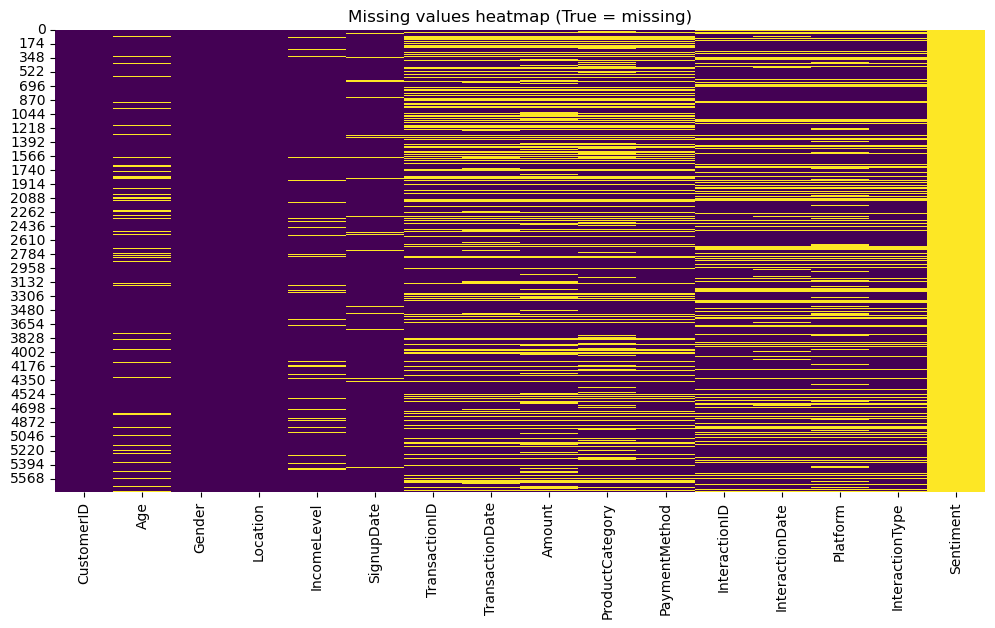

Imputed missing values (categorical and numeric).
Removed 11 duplicate rows.
Finished preprocessing pipeline.


In [27]:
# --- Example usage ---
if __name__ == "__main__":
    csv_paths = [
        "customer_demographics_clean.csv",
        "customer_transactions_clean.csv",
        "social_media_interactions_clean.csv"
    ]
    result = example_pipeline(csv_paths, merge_on="CustomerID")
    pass

Loaded merged dataframe shape: (5729, 16)


C:\Users\GOD IS GOOD\AppData\Local\Temp\ipykernel_4588\2970454406.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=infer)
C:\Users\GOD IS GOOD\AppData\Local\Temp\ipykernel_4588\2970454406.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=infer)
C:\Users\GOD IS GOOD\AppData\Local\Temp\ipykernel_4588\2970454406.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future ver

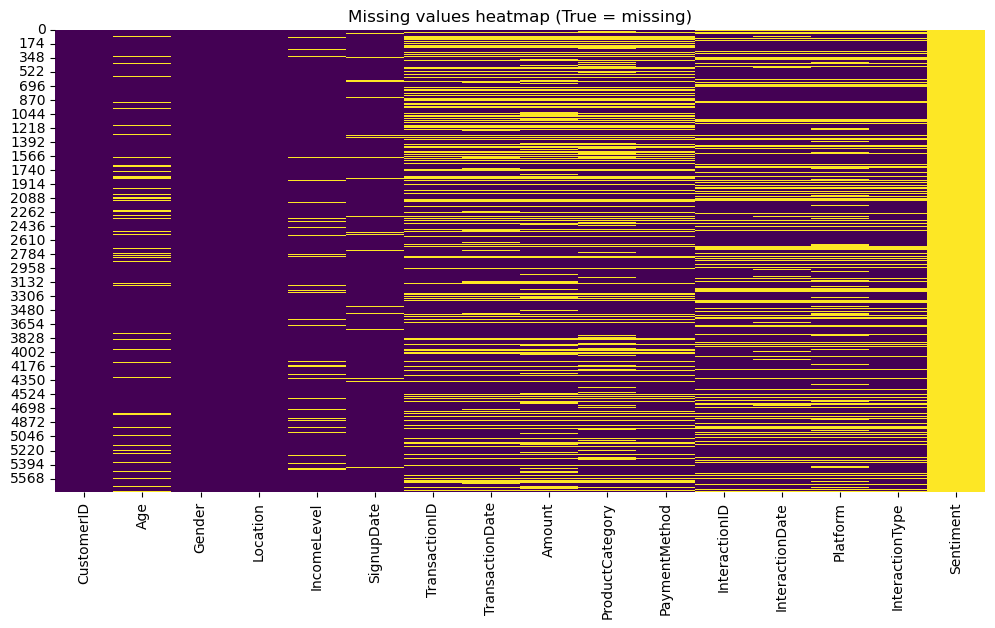

Imputed missing values (categorical and numeric).
Removed 11 duplicate rows.
Finished preprocessing pipeline.
Pipeline complete!
Cleaned dataframe shape: (5718, 16)
Normalized dataframe shape: (5718, 16)
Standardized dataframe shape: (5718, 16)


In [30]:
if __name__ == "__main__":
    csv_paths = [
        "customer_demographics_clean.csv",
        "customer_transactions_clean.csv",
        "social_media_interactions_clean.csv"
    ]

    result = example_pipeline(csv_paths, merge_on="CustomerID")

    #  Access cleaned, normalized, and standardized DataFrames
    df_clean = result["cleaned"]
    df_norm = result["normalized"]
    df_std = result["standardized"]

    print("Pipeline complete!")
    print("Cleaned dataframe shape:", df_clean.shape)
    print("Normalized dataframe shape:", df_norm.shape)
    print("Standardized dataframe shape:", df_std.shape)
